# Run the code in accesnding order according to the number on each markdown for each section.

## 1. Imports

In [45]:
import os
import sys
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
from nltk.tokenize import RegexpTokenizer
import heapq
import math
import copy
import re
from num2words import num2words
from collections import OrderedDict
import pandas as pd
from itertools import permutations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as cs


## 2. Read all the files and create ground truth dictionary to know which file is present in which folder

In [122]:
path = r'/media/rohit/New Volume/codes/IR/20_newsgroups/subset_Assignment_4'
files = []
files1 = []
folder_dict = {}
print(path)
for r, d, f in os.walk(path):
    for file in sorted(f):
        file_path = os.path.join(r, file)
        if file_path.split('/')[-2] not in folder_dict.keys():
            folder_dict[file_path.split('/')[-2]] = []
        else:
            folder_dict[file_path.split('/')[-2]].append(file.split('/')[-1])
#             print(file.split('/')[-1])
        print(file.split('/')[-1])
        files.append(os.path.join(r, file))
        files1.append(file.split('/')[-1])
print(len(files))

/media/rohit/New Volume/codes/IR/20_newsgroups/subset_Assignment_4
37261
37913
37914
37915
37916
37917
37918
37919
37920
37921
37922
37923
37924
37925
37926
37927
37928
37929
37930
37931
37932
37933
37934
37935
37936
37937
37938
37939
37940
37941
37942
37943
37944
37945
37946
37947
37948
37949
37950
37951
37952
37953
37954
37955
37956
37957
37958
37959
37960
37961
37962
37963
38099
38214
38215
38216
38217
38218
38219
38220
38221
38222
38223
38224
38225
38226
38227
38228
38229
38230
38231
38232
38233
38234
38235
38236
38237
38238
38239
38240
38241
38242
38243
38244
38245
38246
38247
38248
38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
383

In [3]:
folder_dict.keys()

dict_keys(['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc'])

## 3. Preprocessing function

In [4]:
def process_query(query):
    punctuations = '''!()-[]{};:"\,<>./?@#$=+%^&*_~'''
    table = str.maketrans({key:" " for key in punctuations})
    query = query.translate(table)
    table = str.maketrans({key:None for key in "'"})
    query = query.translate(table)
    query = query.lower()
    st = PorterStemmer()
    stemm_list = []
    stop = stopwords.words('english')
    tokenizer = RegexpTokenizer(r'\w+')
    query_list = tokenizer.tokenize(query)
    for j in query_list:
        if j.isnumeric():
            j = num2words(j)
        elif j in stop:
            j = ''
        stemm_list.append(st.stem(j))
    return stemm_list

## 4. preprocessing and creating data dictionary

In [5]:
data_dict = {}
data = []
count = 0
docid_list = []
for f in files:
#     print(f)
#     sys.exit()
    if '.htm' in f:
        continue
    else:
        filehandle = open(f,errors='ignore')
        # read a single line
        file = (filehandle.read().replace('\n',' '))
        data_dict[f.split('/')[-1]] = set(process_query(file))
        docid_list.append(f.split('/')[-1])
        count = count + 1
        print(count)
# close the pointer to that file
filehandle.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## 5. Term count and document frequency Dictionary

In [6]:
term_count_dict = {}
term_doc_freq = {}
docid_list = []
count = 0
for f in files:
    if '.htm' in f:
        continue
    else:
        filehandle = open(f,errors='ignore')
            # read a single line
        file = (filehandle.read().replace('\n',' '))
        docid = f.split('/')[-1]
        
        file = process_query(file)
        length = len(file)
        for term in file:
            if term not in term_count_dict.keys():
                term_count_dict[term] =  {}
            if docid not in term_count_dict[term].keys(): 
                term_count_dict[term][docid] = [1, length] 
            elif docid in term_count_dict[term].keys():
                term_count_dict[term][docid][0] = term_count_dict[term][docid][0] + 1
        for term in set(file):
            if term not in term_doc_freq.keys():
                term_doc_freq[term] = 1
            elif term in term_doc_freq.keys():
                term_doc_freq[term] = term_doc_freq[term] + 1
            

## 6. Normalized Term Frequency

In [7]:
term_freq_dict = copy.deepcopy(term_count_dict)
for i in term_freq_dict.keys():
    for j in term_freq_dict[i].keys():
        term_freq_dict[i][j] = term_freq_dict[i][j][0]/term_freq_dict[i][j][1]

## 7. tf-idf

In [8]:
tf_idf_dict = copy.deepcopy(term_freq_dict)
for i in tf_idf_dict.keys():
    for j in tf_idf_dict[i].keys():
        tf_idf_dict[i][j] = tf_idf_dict[i][j]*np.log(len(files)/(term_doc_freq[i]+1))

## 8. vectorize tf-idf

In [9]:
number_docs = len(files)
total_vocab = len(tf_idf_dict.keys())
print(number_docs,total_vocab)

5000 55720


In [132]:
vector_dict = {}
count = 0
for col,term in enumerate(tf_idf_dict.keys()):
    for doc in tf_idf_dict[term].keys():
        
        if doc not in vector_dict.keys():
            count = count + 1 
            vector_dict[doc] = np.zeros((total_vocab))
            vector_dict[doc][col] = tf_idf_dict[term][doc]

        else:
            vector_dict[doc][col] = tf_idf_dict[term][doc]

## 9. Function to vectorize Query tf-idf

In [70]:
def vectorize_query(total_vocab,tf_idf_dict,processed_query_list,query_tfidf_dict):
    Q = np.zeros((total_vocab))
    for col,term in enumerate(tf_idf_dict.keys()):
        if term in processed_query_list:
            print(col,term)
            Q[col] = query_tfidf_dict[term]
    return Q

## 10. Query preprocessing and Query tf-idf

In [66]:
def query_step(total_vocab,tf_idf_dict):
    query = input("Enter the query")
    processed_query_list = process_query(query)
#     print(processed_query_list)

    processed_query_set = set(processed_query_list)

    query_term_count_dict = {}
    count = 0
    length = len(processed_query_list)
    for term in processed_query_list:
        if term not in query_term_count_dict.keys():
            query_term_count_dict[term] =  [1,length]
        else:
            query_term_count_dict[term][0] = query_term_count_dict[term][0] + 1 

    query_tfidf_dict = copy.deepcopy(query_term_count_dict)
    for i in query_tfidf_dict.keys():
        query_tfidf_dict[i] = (query_tfidf_dict[i][0]/query_tfidf_dict[i][1])*np.log(len(files)/(term_doc_freq.setdefault(i,0)+1))
    
    ground_truth = input("Enter ground truth folder: ")
    ground_truth_list = list(folder_dict[ground_truth])
    
    
    Q = vectorize_query(total_vocab,tf_idf_dict,processed_query_list,query_tfidf_dict)
    return ground_truth_list,Q

## 11. cosine similarity

In [135]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, np.transpose(b))/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim
def cosine_similarity(Q,D,k):
    cosine_similarity_dict = {}
    
    for d in D.keys():
#         print(D.keys())
        cosine_similarity_dict[d] = cosine_sim(Q, D[d])
#         print(cosine_similarity_dict[d])
        
    k_keys_sorted = heapq.nlargest(k, cosine_similarity_dict,key=cosine_similarity_dict.get)
    return k_keys_sorted, cosine_similarity_dict

## 12. Function to take feedback and print docs with * which are marked as relevant

In [149]:
def get_feedback(result,relevant,fract,output_main):
    if len(output_main)==0:
        for i in result:
            output_main.append(i)
    for count,i in enumerate(result):
        if i in relevant:
            print(str(count)+" "+i+'*')
        else:
            print(str(count)+" "+i)
    result = [int(s) for s in result]
    number = len(result)*fract/100
    relevant = input("Enter at most "+str(int(number))+" relevant documents: ").split(' ')
#     relevant = [result[int(s)] for s in relevant]
    relevant = relevant[:(int(number))]
    non_relevant = set(result) - set(relevant)
    for count,i in enumerate(result):
        if str(i) in relevant:
            output_main[count] = (str(count)+" "+str(i)+'*')
        else:
            output_main[count] = output_main[count]
    return relevant, list(non_relevant), output_main

## 13. Function to calculate centroid

In [16]:
def centroid(docid):
    l = []
    sum = []
    centroid = []
    for i in docid:
        l.append(vector_dict[str(i)])
    sum = np.sum(l,axis = 0)
    centroid = (sum/len(docid))
    return centroid

## 14. Function to generate TSNE

In [17]:
def gen_tsne(Q_r, Q_nr, Q_m):
    tsne = TSNE(n_components=3, random_state=10)

    feature_vector = []
    labels = []

    for i in Q_r:
        feature_vector.append(vector_dict[str(i)])
        labels.append(0)
    for i in Q_nr:
        feature_vector.append(vector_dict[str(i)])
        labels.append(1)

    feature_vector.append(Q_m)
    labels.append(2)
    print(np.array(feature_vector).shape)
    transformed_data = tsne.fit_transform(np.array(feature_vector))
    k = np.array(transformed_data)
    print(k.shape)
    t = ("Relevant", "Non Relevant", "Query")
    plt.scatter(k[:, 0], k[:, 1], c=labels, s=60, alpha=0.8, label="Violet-R, Aqua-NR")
    plt.title("Rocchio Algorithm")
    plt.legend()
    plt.grid(True)
    plt.show()

## 15. Function to generate PR curve

In [151]:
def get_PnR(output,ground_truth):
    relevant_retrieved = 0
    total_relevant = len(ground_truth)
    recall_list = []
    precision_list = []
    P = []
    print(output)
    for count,i in enumerate(output):
#         print("lol",i)
        if '*' in i:
            relevant_retrieved = relevant_retrieved + 1
            recall = relevant_retrieved/total_relevant
            precision = relevant_retrieved/(count+1)
            print(recall,precision)
            recall_list.append(recall)
            precision_list.append(precision)
            P.append(precision)
        else:
            recall = relevant_retrieved/total_relevant
            precision = relevant_retrieved/(count+1)
            recall_list.append(recall)
            precision_list.append(precision)
    AP = sum(P)/len(P)
    plt.plot(recall_list, precision_list, marker='.')
# axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
# show the legend
    plt.legend()
# show the plot
    plt.show()
    return AP

## 16. Main function to call all other functions and run rocchio iterations and return average precision 

In [144]:
def iterations_rocchio(vector_dict,Q,ground_truth,iterations,alpha,beta,gamma,k,fract):
    flag = False
    output_main = []
    for i in range(iterations):
        if flag == True:
            relevant, non_relevant, prev = previous[0],previous[1],previous[2]
            new = (alpha*prev) + (beta*centroid(relevant)) - (gamma*centroid(non_relevant))
        else:
            new = Q
            flag = True
            relevant = set()
            non_relevant = set()
        
        result,_ = cosine_similarity(new,vector_dict,k)
        print(set(result)&set(ground_truth))
        docs0, docs1, output = get_feedback(result,str(relevant),fract,output_main)
        output_main = output
        relevant = relevant | set(docs0)
        non_relevant = non_relevant | set(docs1)
        print(non_relevant)
        print("relevant: "+str(relevant))
        print("Non relevant: "+str(non_relevant))
        previous = [relevant,non_relevant,new]
        gen_tsne(relevant,non_relevant,new)
        AP=get_PnR(output_main,ground_truth)
        print("Average Precision: ",AP)

    return AP

## Run rocchio itterations and plot TSNE and PR curve and calculate mean average precision

Enter the queryPretty good opinions on biochemistry machines
Enter ground truth folder: sci.med
32 
821 machin
848 pretti
849 good
1594 opinion
10200 biochemistri
{'59504', '59400', '59301', '59115', '59154', '59602', '59393', '59183', '59546', '58987', '59518', '59060', '59233', '58953', '58872', '59116', '59207', '59117', '59637', '59632', '59017', '59488', '59459', '58813', '59529', '58801', '59308', '58082', '59165', '59083', '58155', '59184'}
0 59301
1 59060
2 38523
3 38774
4 59393
5 58801
6 59504
7 59488
8 59602
9 58872
10 59546
11 38837
12 38597
13 59116
14 58082
15 38304
16 59400
17 38416
18 60877
19 58987
20 38845
21 54102
22 38554
23 178311
24 38649
25 38959
26 58813
27 53646
28 53998
29 59518
30 59632
31 39033
32 38742
33 177004
34 59308
35 54098
36 179106
37 39001
38 54726
39 178302
40 176953
41 59637
42 59233
43 53663
44 61329
45 54112
46 38908
47 53762
48 37935
49 39052
50 53791
51 59165
52 60942
53 178486
54 53757
55 59183
56 59083
57 53779
58 61068
59 38240
60 52565
61 

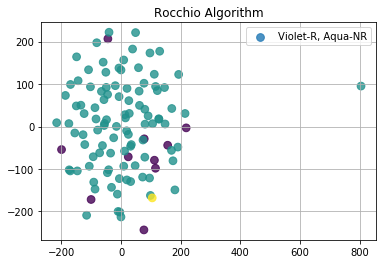

No handles with labels found to put in legend.


['0 59301*', '59060', '38523', '38774', '4 59393*', '58801', '6 59504*', '59488', '8 59602*', '58872', '10 59546*', '38837', '38597', '59116', '58082', '38304', '16 59400*', '38416', '60877', '19 58987*', '38845', '54102', '38554', '178311', '38649', '38959', '58813', '53646', '53998', '59518', '59632', '39033', '38742', '177004', '59308', '54098', '179106', '39001', '54726', '178302', '176953', '59637', '59233', '53663', '61329', '54112', '38908', '53762', '37935', '39052', '53791', '59165', '60942', '178486', '53757', '55 59183*', '59083', '53779', '61068', '38240', '52565', '59459', '53630', '176943', '52552', '65 59115*', '58953', '38549', '61567', '53827', '58155', '38392', '59117', '176902', '62386', '39630', '178382', '53995', '38669', '52653', '59184', '38395', '59207', '59017', '178493', '38438', '59529', '87 59154*', '53677', '178894', '178315', '178804', '38730', '60897', '61444', '53696', '61454', '61246', '61309', '38759']
0.001001001001001001 1.0
0.002002002002002002 0.4


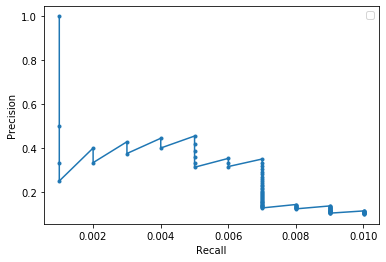

Average Precision:  0.38233596468890585
{'59504', '59400', '59301', '59184', '59115', '59154', '59063', '59602', '59393', '59546', '58987', '59183', '59002', '59060', '59233', '58953', '59073', '58872', '59116', '59548', '59207', '59117', '59632', '59385', '59017', '59488', '59459', '58813', '59529', '58801', '59308', '58082', '59165', '59637', '59083', '58155', '59518'}
0 59301*
1 59060
2 59393*
3 59504*
4 38523
5 59602*
6 58801
7 59488
8 38774
9 59546*
10 59400*
11 58872
12 58987*
13 59116
14 38837
15 58082
16 59518
17 38597
18 38304
19 38416
20 60877
21 58813
22 38845
23 38554
24 54102
25 178311
26 38649
27 38959
28 59632
29 53646
30 53998
31 59165
32 59183*
33 39033
34 177004
35 59308
36 59083
37 54098
38 59115*
39 38742
40 179106
41 59637
42 54726
43 178302
44 176953
45 39001
46 59233
47 54112
48 59154*
49 61329
50 37935
51 53663
52 59459
53 53762
54 53791
55 39052
56 38908
57 60942
58 178486
59 53757
60 58953
61 58155
62 53779
63 61068
64 59207
65 176943
66 38240
67 61567
68 1783

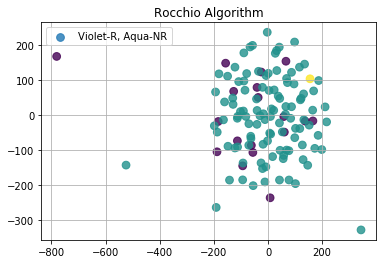

No handles with labels found to put in legend.


['0 59301*', '1 59060*', '38523', '38774', '4 59393*', '58801', '6 59504*', '59488', '8 59602*', '58872', '10 59546*', '11 58872*', '12 58987*', '13 59116*', '58082', '38304', '16 59400*', '38416', '60877', '19 58987*', '38845', '54102', '38554', '178311', '38649', '38959', '58813', '53646', '53998', '59518', '59632', '39033', '32 59183*', '177004', '59308', '54098', '179106', '39001', '54726', '178302', '176953', '59637', '59233', '53663', '61329', '54112', '46 59233*', '53762', '37935', '39052', '53791', '59165', '60942', '178486', '53757', '55 59183*', '59083', '53779', '61068', '38240', '60 58953*', '59459', '53630', '176943', '52552', '65 59115*', '58953', '38549', '61567', '53827', '70 59548*', '38392', '59117', '176902', '62386', '39630', '178382', '53995', '38669', '52653', '59184', '38395', '59207', '59017', '178493', '85 59073*', '59529', '87 59154*', '53677', '89 59002*', '178315', '178804', '38730', '60897', '61444', '53696', '61454', '61246', '61309', '38759']
0.0010010010

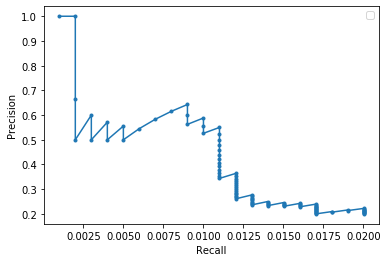

Average Precision:  0.47588386533240745
{'59504', '59400', '59301', '59395', '59184', '59115', '59154', '59063', '59602', '59546', '59393', '58987', '59183', '59002', '58821', '59233', '59060', '58953', '59333', '59073', '58872', '59116', '59548', '59207', '58066', '59117', '59632', '59385', '59017', '59488', '59459', '58813', '59529', '58801', '59308', '58082', '59165', '59637', '59083', '58155', '59518'}
0 59301*
1 59060*
2 59393*
3 59504*
4 59602*
5 38523
6 59400*
7 59546*
8 59488
9 58801
10 58987*
11 59116*
12 38774
13 58872*
14 59518
15 38837
16 58082
17 38304
18 58813
19 38597
20 38416
21 60877
22 59183*
23 59632
24 59165
25 38554
26 59233*
27 38845
28 178311
29 54102
30 38959
31 38649
32 53646
33 59115*
34 59083
35 53998
36 59154*
37 177004
38 39033
39 59308
40 54098
41 59637
42 179106
43 176953
44 59459
45 54726
46 178302
47 38742
48 58953*
49 39001
50 54112
51 61329
52 59548*
53 37935
54 59002*
55 53791
56 59073*
57 53762
58 53663
59 58155
60 39052
61 178486
62 60942
63 38908


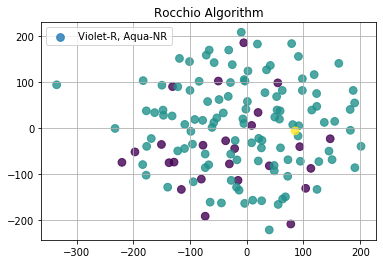

No handles with labels found to put in legend.


['0 59301*', '1 59060*', '38523', '38774', '4 59393*', '58801', '6 59504*', '59488', '8 59488*', '58872', '10 59546*', '11 59116*', '12 58987*', '13 58872*', '58082', '38304', '16 59400*', '38416', '60877', '19 58987*', '38845', '54102', '38554', '23 59632*', '38649', '38959', '58813', '53646', '53998', '59518', '59632', '39033', '32 59183*', '177004', '59308', '54098', '179106', '39001', '54726', '178302', '176953', '59637', '59233', '53663', '61329', '54112', '46 59233*', '53762', '37935', '39052', '53791', '59165', '52 59548*', '178486', '53757', '55 59183*', '59083', '53779', '61068', '38240', '60 58953*', '59459', '53630', '176943', '64 59207*', '65 59115*', '58953', '38549', '61567', '53827', '70 59548*', '38392', '72 59385*', '176902', '62386', '39630', '178382', '53995', '38669', '52653', '59184', '81 59017*', '59207', '59017', '178493', '85 59073*', '59529', '87 59154*', '53677', '89 59002*', '178315', '178804', '38730', '60897', '61444', '53696', '96 59117*', '61246', '98 580

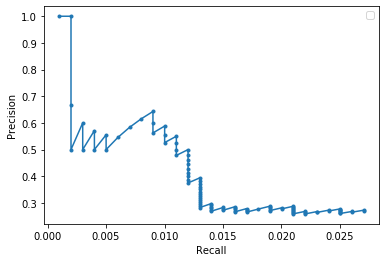

Average Precision:  0.44639458566617174
Enter the queryScientific tools for preserving rights and body
Enter ground truth folder: talk.politics.misc
32 
70 scientif
356 right
643 tool
5867 bodi
13495 preserv
{'178713', '179045', '178409', '176858', '178754', '178724', '178913', '176974', '178546', '179106', '178776', '178540', '178304', '178738', '176970', '178817'}
0 61335
1 59434
2 58569
3 59137
4 38375
5 38852
6 58900
7 61079
8 61385
9 58775
10 61307
11 60809
12 60819
13 178913
14 58898
15 58910
16 59291
17 61357
18 60820
19 39655
20 178540
21 58921
22 59606
23 60797
24 61456
25 179106
26 59233
27 178738
28 59548
29 58719
30 61009
31 61319
32 58981
33 58947
34 59371
35 178754
36 39736
37 59338
38 37920
39 58053
40 58997
41 61299
42 59071
43 58131
44 59913
45 61301
46 176974
47 61118
48 37919
49 58052
50 60229
51 61331
52 58882
53 59582
54 178546
55 38593
56 58792
57 178776
58 38816
59 38609
60 176970
61 59273
62 37261
63 58961
64 58840
65 60248
66 38626
67 59576
68 59635
69 38484
70

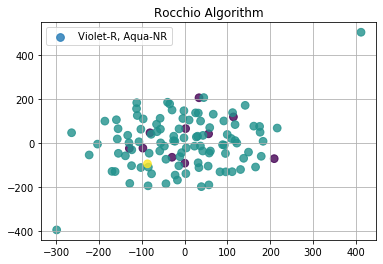

No handles with labels found to put in legend.


['61335', '59434', '58569', '59137', '38375', '38852', '58900', '61079', '61385', '58775', '61307', '60809', '60819', '13 178913*', '58898', '58910', '59291', '61357', '60820', '39655', '178540', '58921', '59606', '60797', '61456', '25 179106*', '59233', '178738', '59548', '58719', '61009', '61319', '58981', '58947', '59371', '35 178754*', '39736', '59338', '37920', '58053', '58997', '61299', '59071', '58131', '59913', '61301', '46 176974*', '61118', '37919', '58052', '60229', '61331', '58882', '59582', '54 178546*', '38593', '58792', '178776', '38816', '38609', '176970', '59273', '37261', '58961', '58840', '60248', '38626', '59576', '59635', '38484', '58108', '38409', '59069', '73 179045*', '61425', '178304', '58045', '59034', '59183', '58941', '80 178713*', '61241', '61413', '39055', '61383', '38879', '61273', '61257', '38311', '39057', '178817', '91 178724*', '60872', '60938', '58880', '38376', '38853', '97 176858*', '38845', '99 178409*']
0.001001001001001001 0.07142857142857142
0.

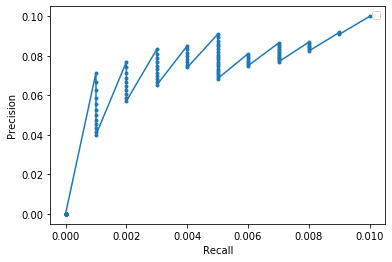

Average Precision:  0.08539945461733048
{'178713', '178546', '178684', '178304', '176873', '178540', '178340', '178817', '179045', '176858', '178724', '178877', '176859', '178738', '176970', '178409', '176929', '178754', '176974', '179106', '178776', '178913'}
0 61335
1 59434
2 58569
3 59137
4 38375
5 38852
6 58900
7 61079
8 61385
9 61307
10 58775
11 178913*
12 60819
13 60809
14 61357
15 58898
16 58910
17 179106*
18 178540
19 59291
20 60820
21 178754*
22 178738
23 61456
24 39655
25 58921
26 59606
27 176974*
28 60797
29 61319
30 59548
31 59233
32 58981
33 61009
34 58719
35 58947
36 59371
37 178546*
38 61299
39 179045*
40 59338
41 39736
42 178776
43 178713*
44 61301
45 58997
46 59071
47 37920
48 58053
49 176858*
50 59913
51 58131
52 61118
53 178409*
54 176970
55 178724*
56 59582
57 37919
58 58052
59 178304
60 58882
61 60229
62 61331
63 58792
64 58961
65 58840
66 59273
67 38593
68 38816
69 60248
70 38609
71 59069
72 38484
73 37261
74 59576
75 58108
76 59183
77 59635
78 61425
79 38626
80 5

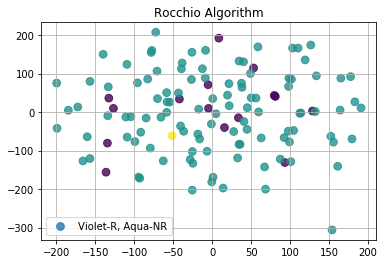

No handles with labels found to put in legend.


['61335', '59434', '58569', '59137', '38375', '38852', '58900', '61079', '61385', '58775', '61307', '60809', '60819', '13 178913*', '58898', '58910', '59291', '17 179106*', '60820', '39655', '178540', '21 178754*', '22 178738*', '60797', '61456', '25 179106*', '59233', '27 176974*', '59548', '58719', '61009', '61319', '58981', '58947', '59371', '35 178754*', '39736', '59338', '37920', '58053', '58997', '61299', '59071', '58131', '59913', '61301', '46 176974*', '61118', '37919', '58052', '60229', '61331', '58882', '53 178409*', '54 176970*', '55 178724*', '58792', '178776', '38816', '38609', '176970', '59273', '37261', '58961', '58840', '60248', '38626', '59576', '59635', '38484', '58108', '38409', '59069', '73 179045*', '61425', '178304', '58045', '59034', '59183', '58941', '80 178713*', '61241', '61413', '39055', '61383', '38879', '61273', '61257', '38311', '89 178877*', '178817', '91 178724*', '60872', '60938', '94 176929*', '38376', '38853', '97 176858*', '38845', '99 176859*']
0.00

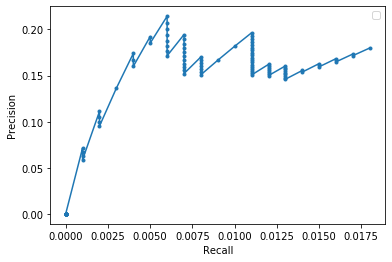

Average Precision:  0.16511810348978112
{'178713', '178913', '178546', '178519', '178684', '178616', '176873', '178799', '178540', '178340', '178817', '179045', '176858', '178724', '178877', '176859', '178738', '176970', '178409', '176929', '178754', '176974', '179106', '178776', '178304', '176905'}
0 61335
1 59434
2 58569
3 59137
4 38375
5 38852
6 58900
7 178913*
8 61079
9 61307
10 61385
11 58775
12 179106*
13 61357
14 178754*
15 178540
16 178738*
17 60819
18 60809
19 58910
20 58898
21 176974*
22 59291
23 60820
24 61456
25 179045*
26 61319
27 176858*
28 178546*
29 58921
30 59606
31 178776
32 178409*
33 39655
34 178713*
35 60797
36 59548
37 178724*
38 59233
39 58981
40 61299
41 61009
42 58947
43 176970*
44 58719
45 59371
46 59338
47 61301
48 39736
49 61118
50 59071
51 178304
52 59913
53 58131
54 58997
55 37920
56 58053
57 176859*
58 178877*
59 176873
60 176929*
61 59582
62 58882
63 58792
64 178340
65 178684
66 60229
67 37919
68 58052
69 61331
70 58840
71 58961
72 59069
73 59273
74 6024

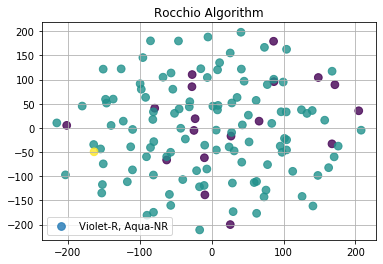

No handles with labels found to put in legend.


['61335', '59434', '58569', '59137', '38375', '38852', '58900', '61079', '61385', '58775', '61307', '60809', '12 179106*', '13 178913*', '14 178754*', '58910', '16 178738*', '17 179106*', '60820', '39655', '178540', '21 176974*', '22 178738*', '60797', '61456', '25 179106*', '59233', '27 176974*', '59548', '58719', '61009', '31 178776*', '32 178409*', '58947', '59371', '35 178754*', '39736', '59338', '37920', '58053', '58997', '61299', '59071', '43 176970*', '59913', '61301', '46 176974*', '61118', '37919', '58052', '60229', '51 178304*', '58882', '53 178409*', '54 176970*', '55 178724*', '58792', '178776', '38816', '38609', '60 176929*', '59273', '37261', '58961', '58840', '60248', '38626', '59576', '59635', '38484', '58108', '38409', '59069', '73 179045*', '61425', '178304', '58045', '59034', '59183', '58941', '80 178713*', '61241', '61413', '39055', '61383', '38879', '61273', '61257', '88 176905*', '89 178877*', '178817', '91 178724*', '60872', '60938', '94 176929*', '38376', '38853

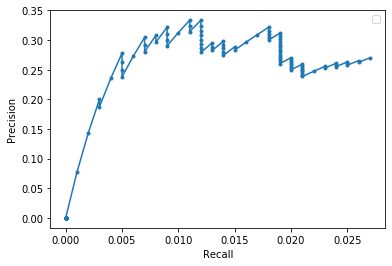

Average Precision:  0.2714779277601682
Enter the queryFrequently asked questions on State-of-the-art visualisation tools
Enter ground truth folder: sci.med
22 state
32 
237 ask
643 tool
667 art
1037 question
2520 frequent
2828 visualis
{'58088', '58121', '58974', '59310', '58792', '59493', '58569', '59434', '59582', '58052', '59009', '58887', '58957', '59064', '58838', '58053', '59410', '58139', '59370'}
0 62126
1 61335
2 59434
3 58569
4 58957
5 38997
6 61371
7 38429
8 38375
9 38852
10 61079
11 58974
12 178540
13 60809
14 38971
15 61146
16 38962
17 60819
18 60820
19 37919
20 58052
21 59370
22 178546
23 61456
24 39655
25 38636
26 60797
27 61385
28 178908
29 60860
30 59871
31 38951
32 37920
33 58053
34 38236
35 38400
36 178340
37 60902
38 39736
39 178450
40 60827
41 60863
42 58139
43 61553
44 38821
45 60843
46 60900
47 38226
48 60215
49 61009
50 62131
51 38912
52 39021
53 60889
54 58792
55 38460
56 61313
57 60824
58 38853
59 38376
60 60850
61 38593
62 39634
63 178550
64 61241
65 38626
66

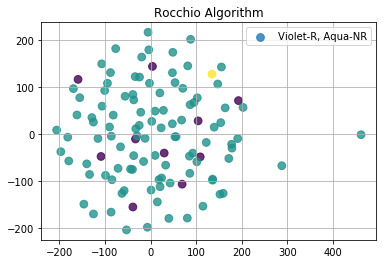

No handles with labels found to put in legend.


['62126', '61335', '2 59434*', '3 58569*', '58957', '38997', '61371', '38429', '38375', '38852', '61079', '11 58974*', '178540', '60809', '38971', '61146', '38962', '60819', '60820', '37919', '20 58052*', '59370', '178546', '61456', '39655', '38636', '60797', '61385', '178908', '60860', '59871', '38951', '37920', '58053', '38236', '38400', '178340', '60902', '39736', '178450', '60827', '60863', '58139', '61553', '38821', '60843', '60900', '38226', '60215', '61009', '62131', '38912', '39021', '60889', '54 58792*', '38460', '61313', '60824', '38853', '38376', '60850', '38593', '39634', '178550', '61241', '38626', '38409', '60963', '58838', '38484', '53931', '38778', '58887', '38906', '60955', '53588', '38823', '38817', '54061', '179058', '59009', '38311', '59410', '38955', '84 59493*', '38827', '38577', '59904', '88 58121*', '178707', '39055', '53576', '92 58088*', '38223', '62373', '54242', '60808', '97 59582*', '59064', '99 59310*']
0.001001001001001001 0.3333333333333333
0.00200200200

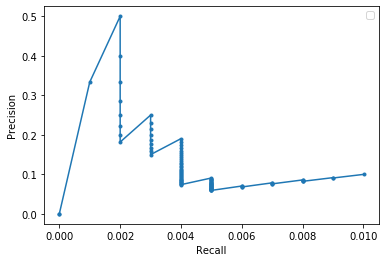

Average Precision:  0.1791816775476212
{'58088', '59100', '58121', '58974', '59310', '58792', '59063', '59493', '58569', '59434', '59582', '58052', '59009', '58887', '58957', '59064', '58838', '58053', '58124', '59410', '58139', '59370'}
0 59434*
1 61335
2 62126
3 58569*
4 58957
5 38997
6 61371
7 38429
8 58974*
9 38375
10 38852
11 37919
12 58052*
13 61079
14 178540
15 61146
16 60809
17 38971
18 60819
19 38962
20 59370
21 60820
22 37920
23 58053
24 178546
25 61385
26 61456
27 38636
28 59493*
29 178908
30 39655
31 58088*
32 59871
33 60797
34 58139
35 58792*
36 58121*
37 60860
38 38400
39 38236
40 178340
41 38951
42 59310*
43 178450
44 39736
45 60902
46 60827
47 61553
48 59582*
49 60863
50 38821
51 59064
52 38853
53 38376
54 60215
55 60843
56 38226
57 61009
58 60900
59 38912
60 38460
61 39021
62 61313
63 62131
64 60889
65 61241
66 178550
67 38778
68 60824
69 38593
70 58838
71 59100
72 60850
73 39634
74 179058
75 58887
76 38484
77 38906
78 38626
79 38409
80 60963
81 38311
82 59904
83 59009

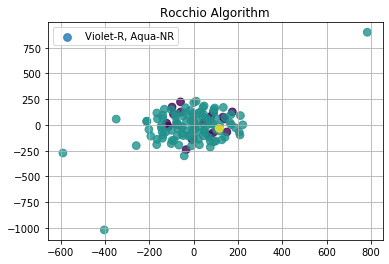

No handles with labels found to put in legend.


['62126', '61335', '2 59434*', '3 58569*', '4 58957*', '38997', '61371', '38429', '38375', '38852', '61079', '11 58974*', '12 58052*', '60809', '38971', '61146', '38962', '60819', '60820', '37919', '20 58052*', '59370', '178546', '23 58053*', '39655', '38636', '60797', '61385', '178908', '60860', '59871', '38951', '37920', '58053', '38236', '38400', '178340', '60902', '39736', '178450', '60827', '60863', '58139', '61553', '38821', '60843', '60900', '38226', '48 59582*', '61009', '62131', '51 59064*', '39021', '60889', '54 58792*', '38460', '61313', '60824', '38853', '38376', '60850', '38593', '39634', '178550', '61241', '38626', '38409', '60963', '58838', '38484', '70 58838*', '38778', '58887', '38906', '60955', '75 58887*', '38823', '38817', '54061', '179058', '59009', '38311', '59410', '83 59009*', '84 59410*', '38827', '38577', '59904', '88 58121*', '178707', '39055', '53576', '92 58088*', '38223', '62373', '95 58124*', '60808', '97 59582*', '59064', '99 59310*']
0.00100100100100100

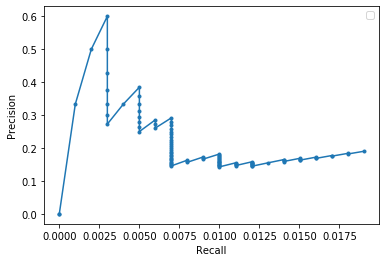

Average Precision:  0.2510765608115142
{'58088', '59100', '58121', '59178', '58974', '59310', '58792', '59063', '59493', '58917', '58569', '59434', '59079', '59582', '58052', '59009', '58887', '58957', '59064', '58838', '58053', '58124', '59410', '58139', '58083', '58947', '59137', '59370'}
0 59434*
1 61335
2 62126
3 58569*
4 58957*
5 58974*
6 37919
7 58052*
8 61371
9 38997
10 38429
11 38375
12 38852
13 37920
14 58053*
15 61079
16 178540
17 61146
18 58088*
19 59493*
20 60809
21 38971
22 60819
23 59370
24 61385
25 58121*
26 60820
27 38962
28 178546
29 61456
30 59310*
31 38636
32 59064*
33 58792*
34 178908
35 58139
36 59871
37 39655
38 59582*
39 60797
40 178340
41 38400
42 60860
43 38236
44 38951
45 178450
46 39736
47 38853
48 38376
49 61553
50 59100
51 58887*
52 60215
53 60827
54 58838*
55 60902
56 59410*
57 58124*
58 38821
59 60863
60 59009*
61 38226
62 60843
63 38460
64 61009
65 61313
66 178550
67 61241
68 38912
69 60900
70 38778
71 39021
72 179058
73 62131
74 60889
75 60824
76 38409


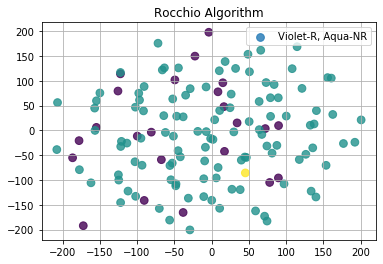

No handles with labels found to put in legend.


['62126', '61335', '2 59434*', '3 58569*', '4 58957*', '38997', '61371', '38429', '38375', '38852', '61079', '11 58974*', '12 58052*', '60809', '14 58053*', '61146', '38962', '60819', '60820', '37919', '20 58052*', '59370', '178546', '23 59370*', '39655', '38636', '60797', '61385', '178908', '60860', '59871', '38951', '32 59064*', '58053', '38236', '35 58139*', '178340', '60902', '39736', '178450', '60827', '60863', '58139', '61553', '38821', '60843', '60900', '38226', '48 59582*', '61009', '62131', '51 59064*', '39021', '60889', '54 58838*', '38460', '56 59410*', '57 58124*', '38853', '38376', '60850', '38593', '39634', '178550', '61241', '38626', '38409', '60963', '58838', '38484', '70 58838*', '38778', '58887', '38906', '60955', '75 58887*', '38823', '77 59137*', '54061', '179058', '59009', '38311', '59410', '83 59009*', '84 59410*', '85 58083*', '38577', '59904', '88 58121*', '89 58947*', '39055', '53576', '92 58088*', '38223', '62373', '95 58124*', '60808', '97 59582*', '59064', '

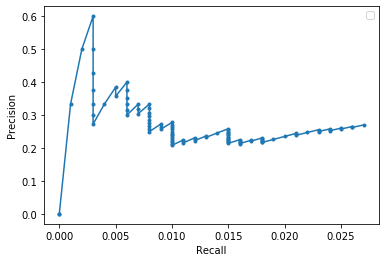

Average Precision:  0.2928267119483277
0.33689974179155585


In [150]:
ground_truth,Q1 = query_step(total_vocab, tf_idf_dict)
AP1 = iterations_rocchio(vector_dict,Q1,ground_truth,3,1,0.7,0.25,100,10)
ground_truth,Q2 = query_step(total_vocab, tf_idf_dict)
AP2 = iterations_rocchio(vector_dict,Q2,ground_truth,3,1,0.7,0.25,100,10)
ground_truth,Q3 = query_step(total_vocab, tf_idf_dict)
AP3 = iterations_rocchio(vector_dict,Q3,ground_truth,3,1,0.7,0.25,100,10)
MAP = (AP1 + AP2 + AP3)/3
print(MAP)